# Miner signature analysis

Data from Neptune and the Monero Archival Project, Analysis by Isthmus

Examining the information leaked by both the nonce search strategy and how the coinbase tx_extra is used

## Import libraries

In [1]:
import isthmuslib
import pandas as pd
import pathlib
from typing import List, Set
from copy import deepcopy

## Misc things that might be useful later

In [2]:
def flip_bitstring(nonce: int, range_num_bits: int = 32) -> int:
    return int(format(nonce, 'b').zfill(range_num_bits)[::-1], 2)

In [3]:
randomx_height: int = 1978433

## Load the data

In [4]:
data_path: pathlib.Path = pathlib.Path.cwd() / 'data' / 'local_only' / 'study_isthmus_coinbase_data.csv'
if not data_path.exists():
    raise ValueError(f"Specified file does not exist: {data_path}")
df = pd.read_csv(data_path)

## Visualize

First where are nonces sampled from?

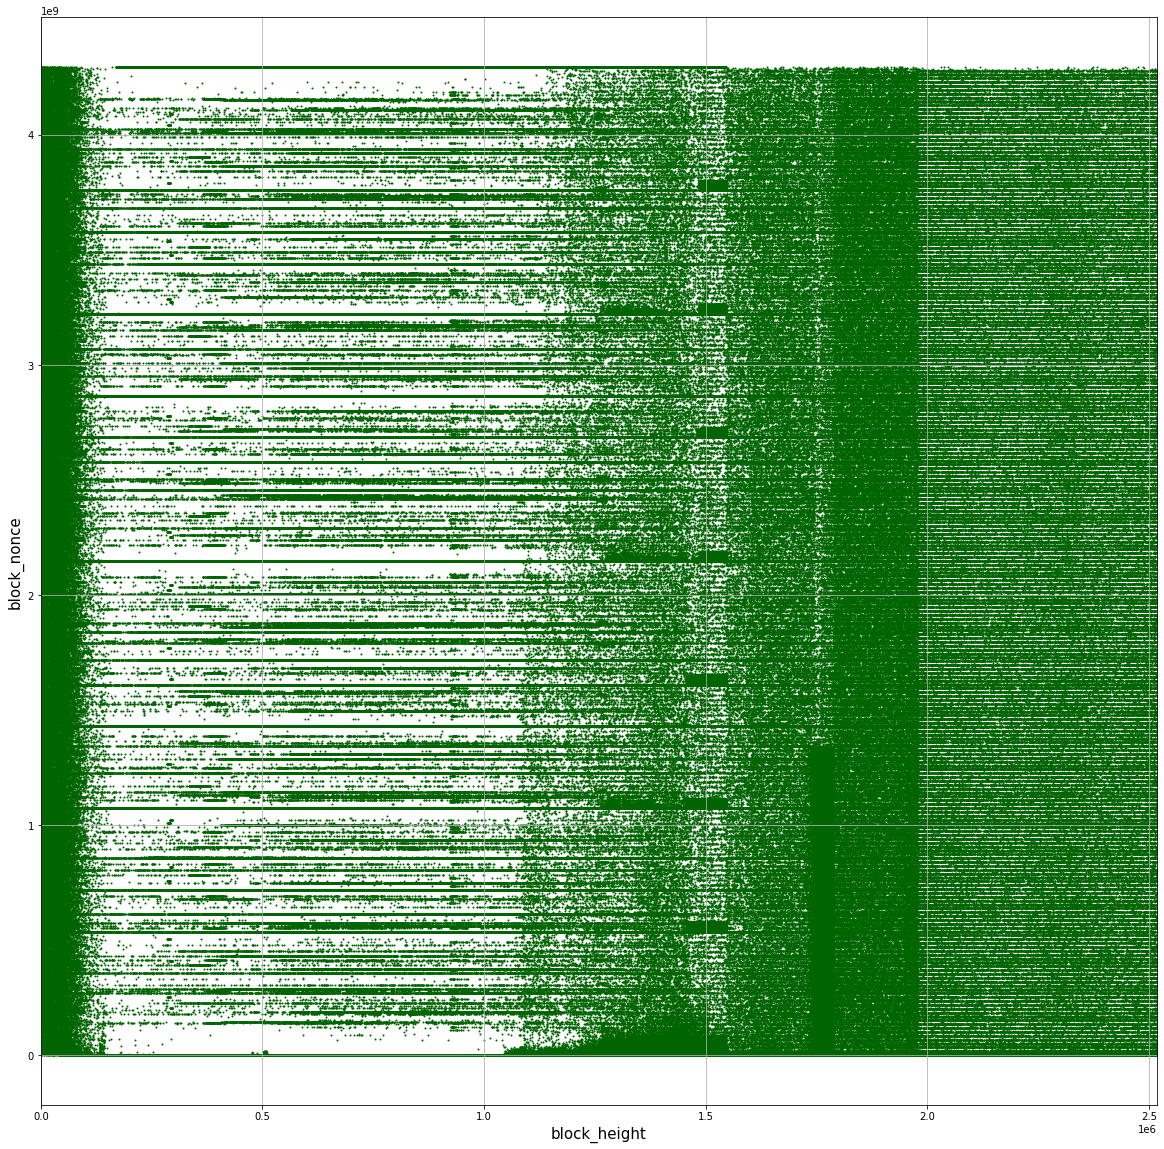

In [5]:
isthmuslib.scatter(df, 'block_height', 'block_nonce', markersize= 1, figsize=(20,20));

Look at recent (RandomX blocks) on log y-axis

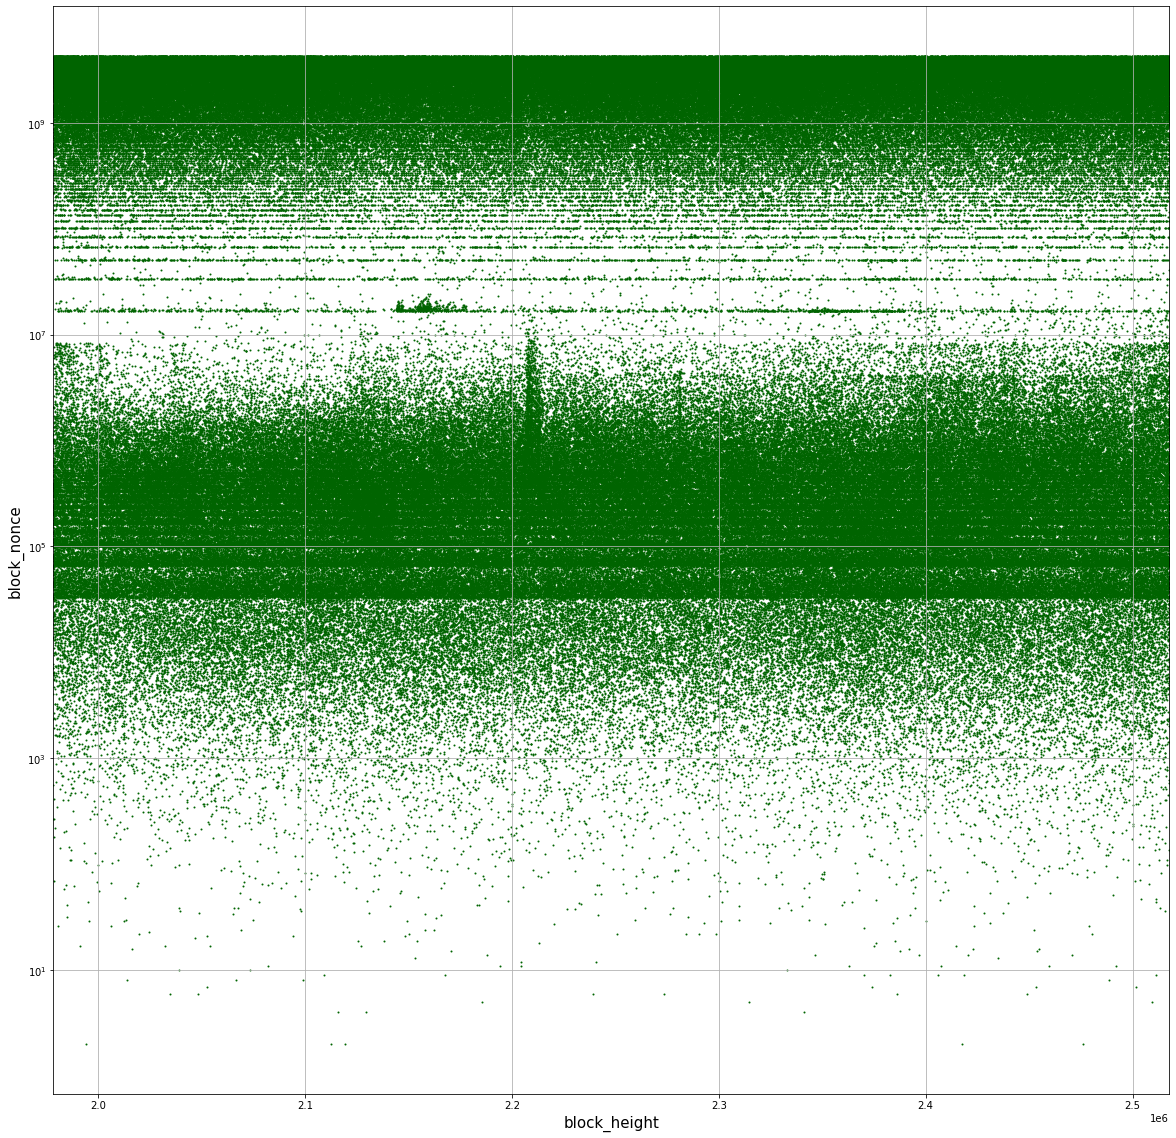

In [6]:
randomx_filter: pd.Series = df['block_height'] > randomx_height
isthmuslib.scatter(df[randomx_filter], 'block_height', 'block_nonce', markersize= 1, figsize=(20,20), log_axes='y');

Isolate some of the lengths that might be viable for hashrate fingerprinting like the Firo forensic analysis

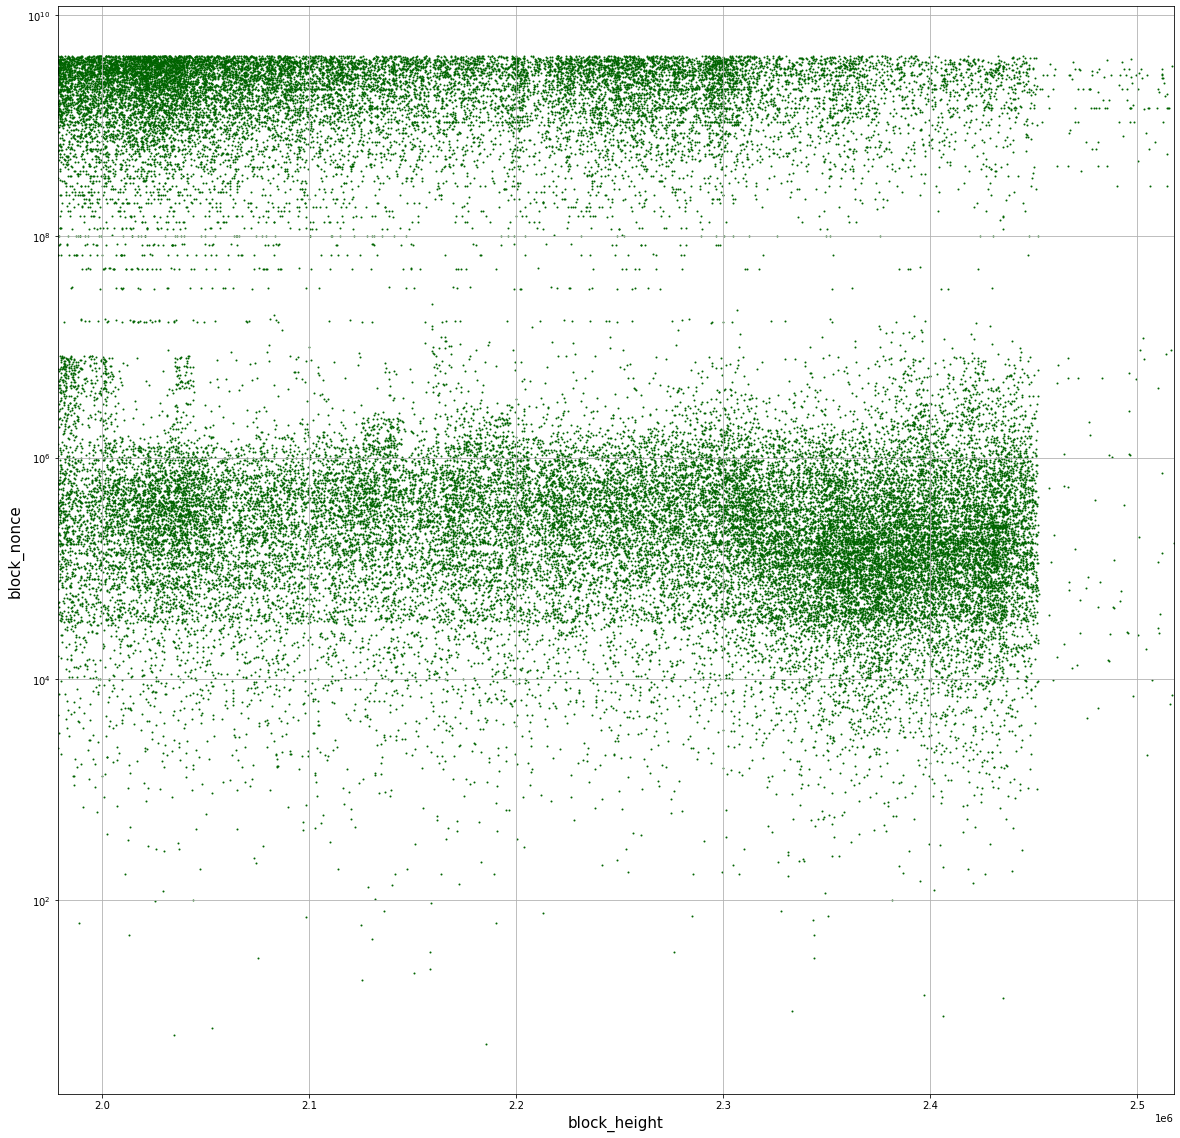

In [7]:
view_lengths: List[int] = [39, -43, -52, -62, 99]
is_view_length: List[bool] = df['coinbase_len_tx_extra'].isin(view_lengths)
isthmuslib.scatter(df[[all(x) for x in zip(randomx_filter, is_view_length)]], 'block_height', 'block_nonce', markersize= 1, figsize=(20,20), log_axes='y');

What are the coinbase tx_extra length signatures?

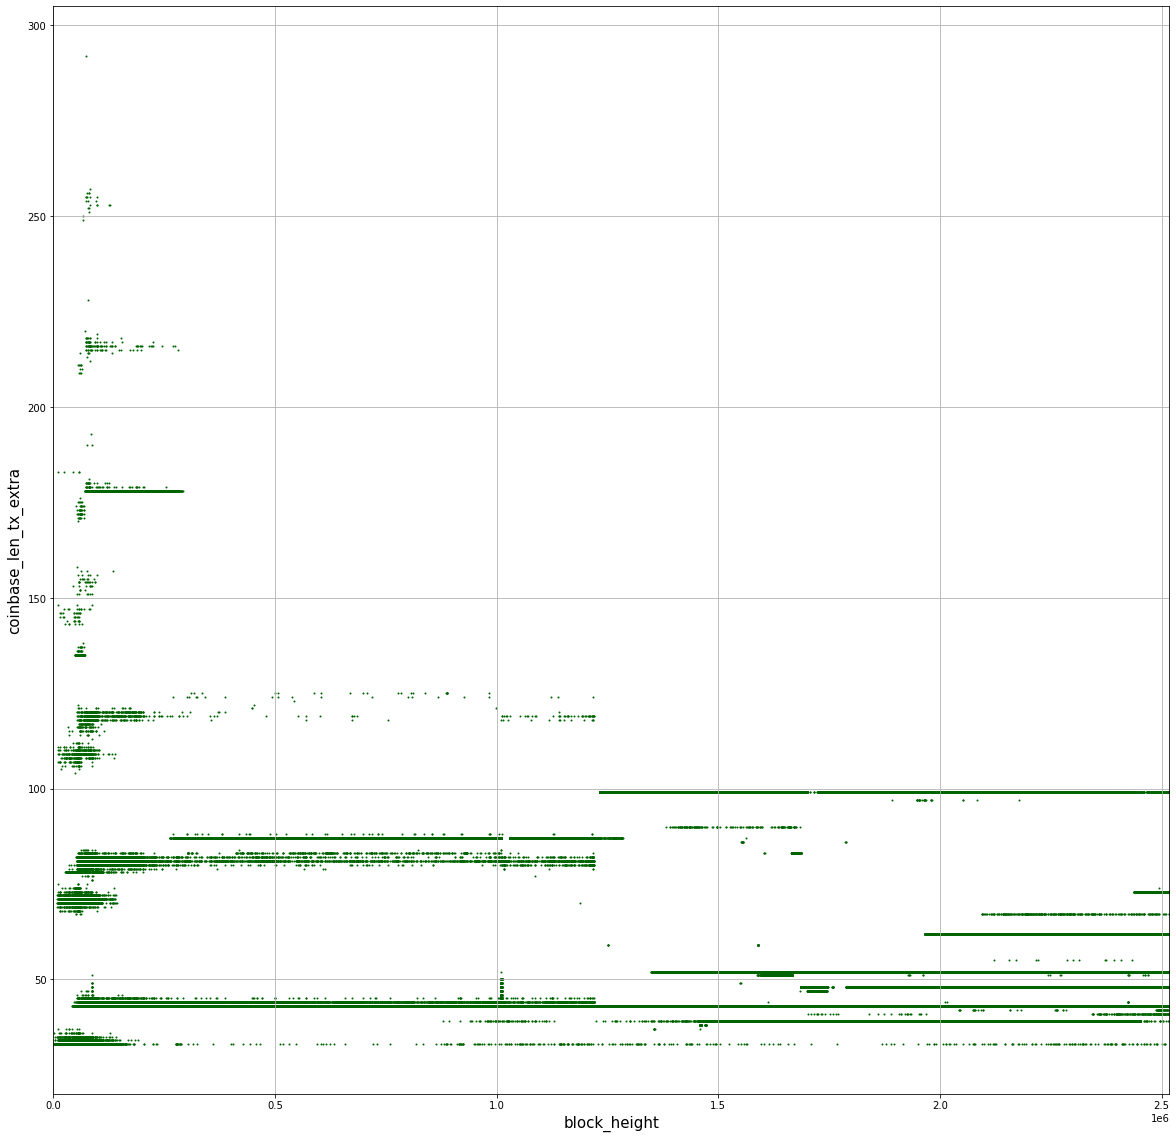

In [8]:
isthmuslib.scatter(df, 'block_height', 'coinbase_len_tx_extra', markersize=1, figsize=(20, 20));

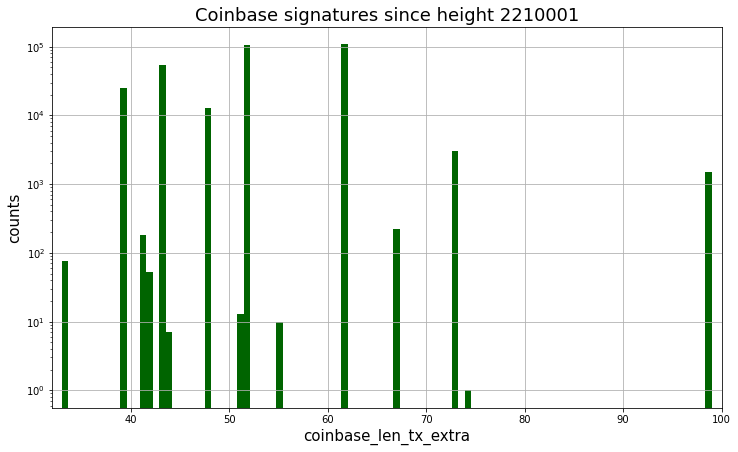

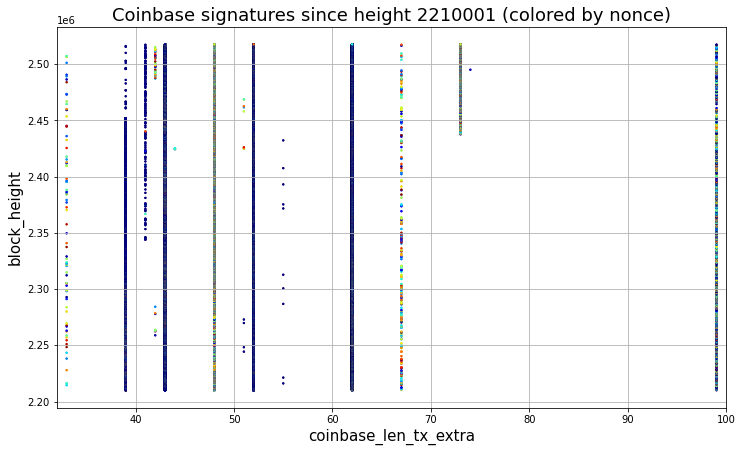

In [9]:
df_recent: pd.DataFrame = deepcopy(df[df['block_height'] > 2210000])
isthmuslib.hist(df_recent, 'coinbase_len_tx_extra', bins=100, log_axes='y', figsize=(12,7), 
                xlim=(32,100), title=f'Coinbase signatures since height {(m:=min(df_recent.block_height))}')
isthmuslib.scatter(df_recent, 'coinbase_len_tx_extra', 'block_height', markersize= 1, figsize=(12,7), 
                xlim=(32,100), title=f'Coinbase signatures since height {m} (colored by nonce)',
                c=df_recent.loc[:,'block_nonce'], cmap='jet');
isthmuslib.plt.scatter(df_recent['coinbase_len_tx_extra'], df_recent['block_height'], 2, df_recent['block_nonce'], cmap='jet');

How many signatures are active?

In [10]:
signatures: Set[int] = set(df_recent.coinbase_len_tx_extra.tolist())
print(f"Currently {len(signatures)} signatures active (since height {m}):\n\nlengths: {sorted(list(signatures))}")

Currently 15 signatures active (since height 2210001):

lengths: [33, 39, 41, 42, 43, 44, 48, 51, 52, 55, 62, 67, 73, 74, 99]


Plot the recent signatures individually. Some of the search patterns are easy to see on linear y-axes, others are easier to see on log y-axes, so we'll plot both here (along with a histogram of activity)

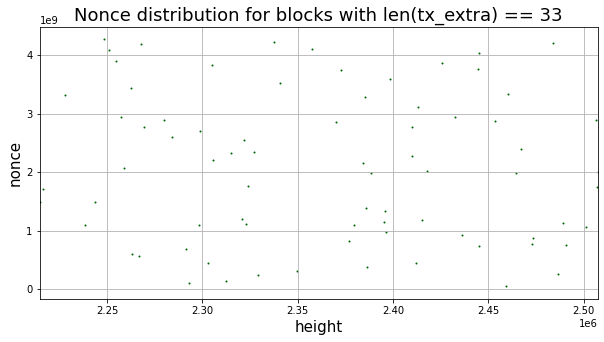

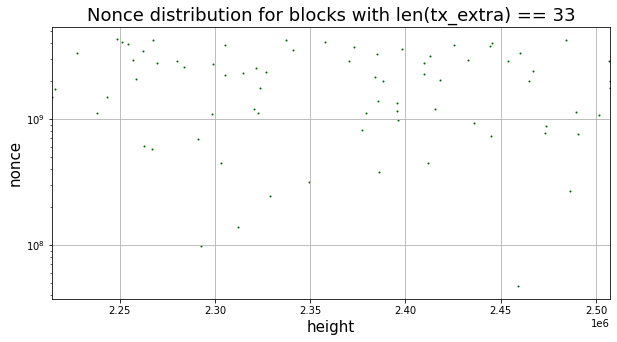

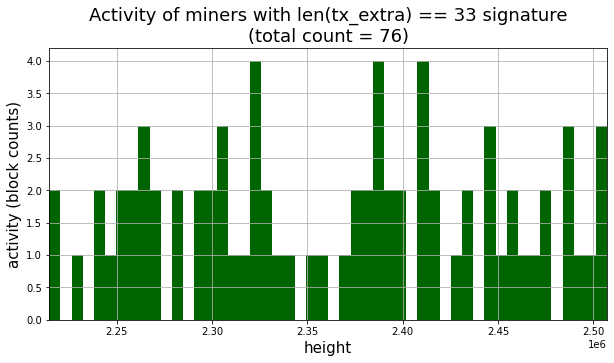

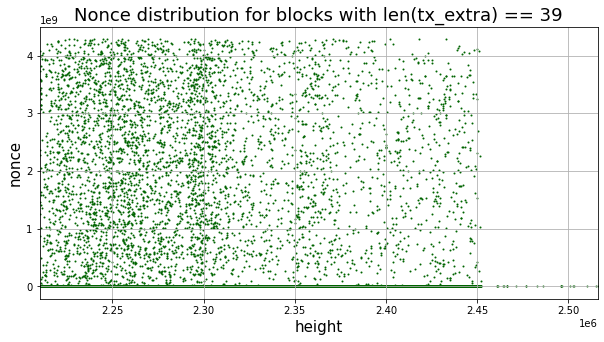

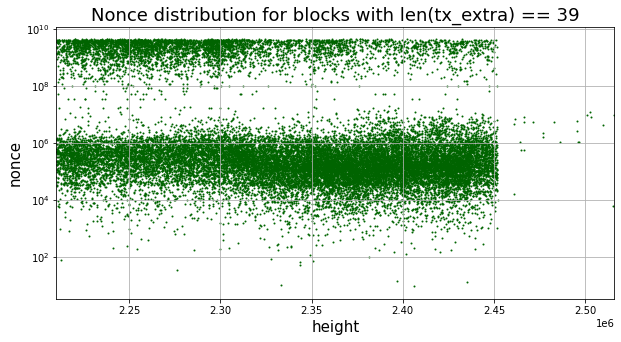

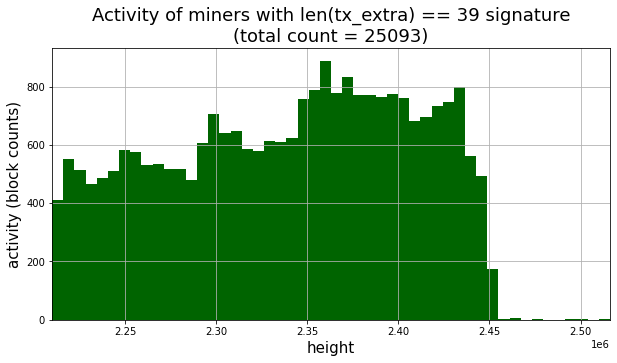

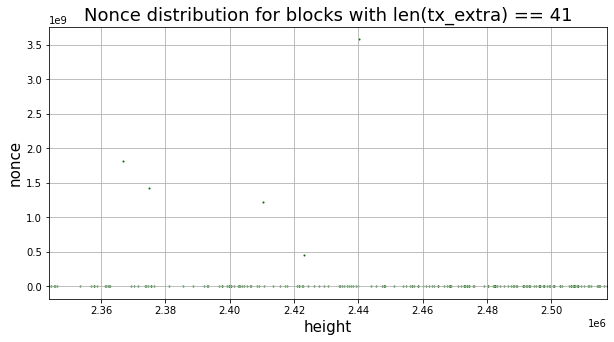

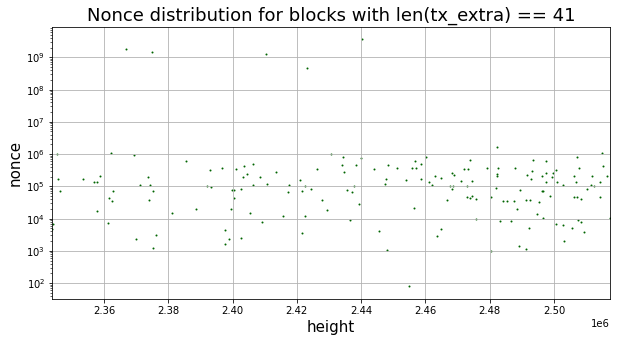

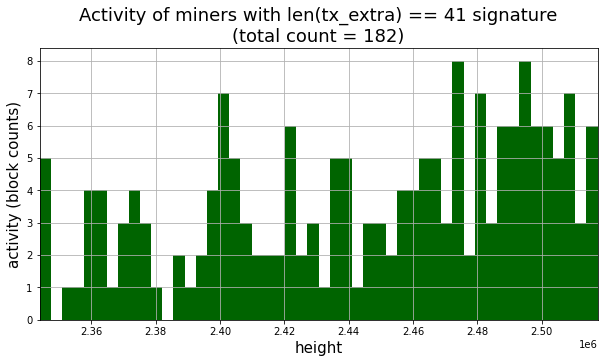

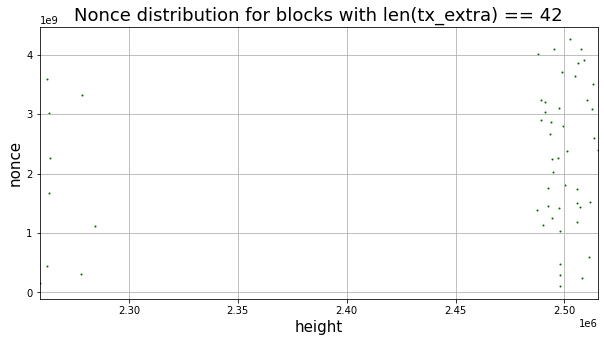

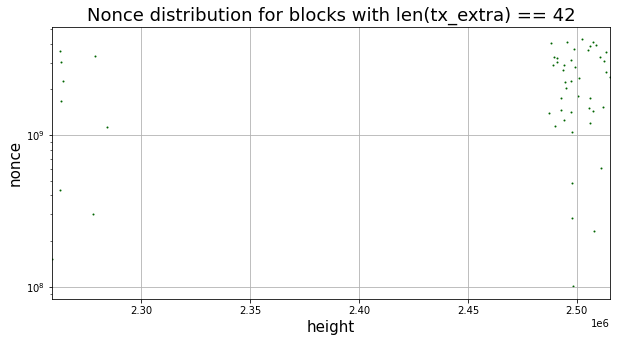

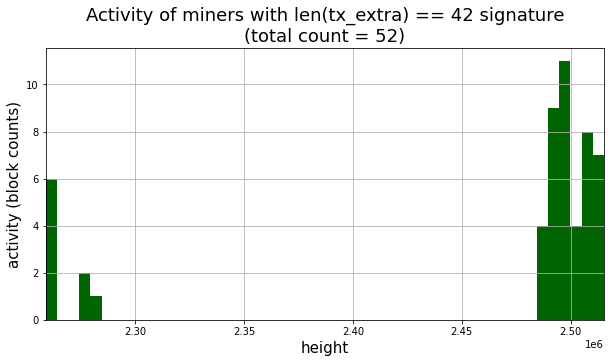

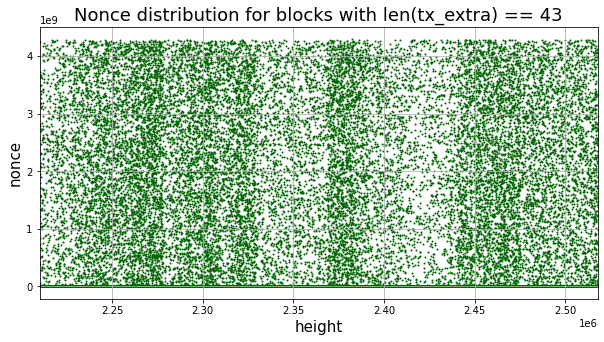

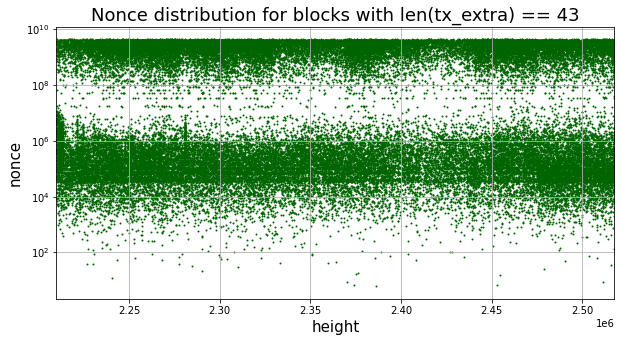

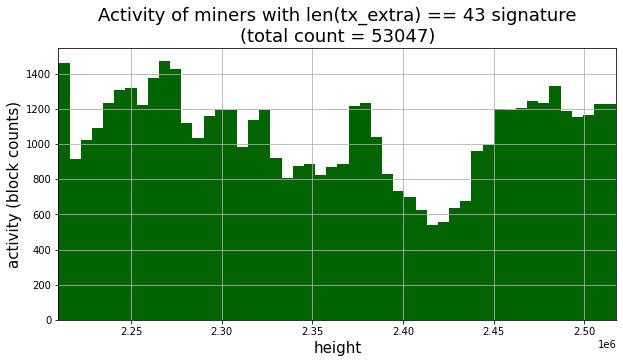

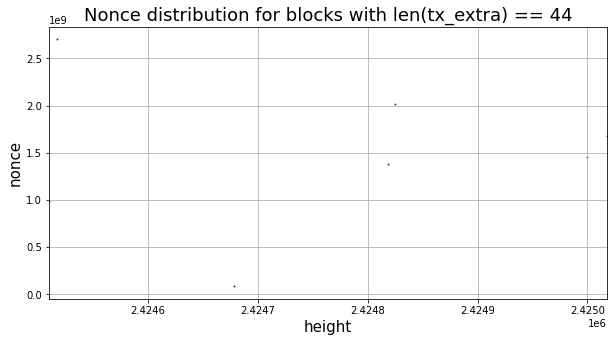

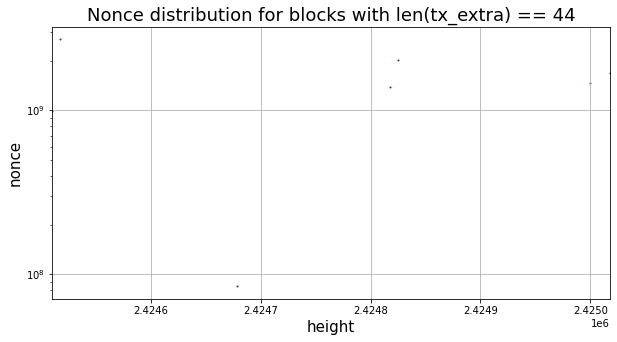

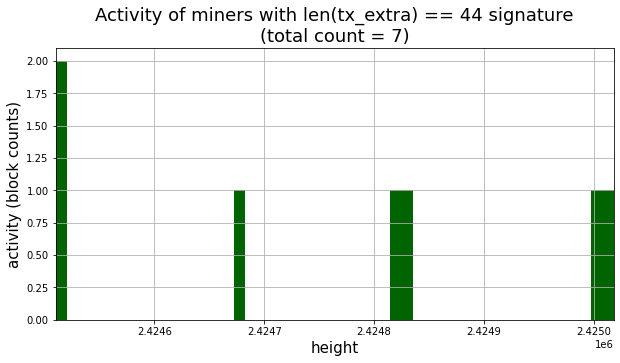

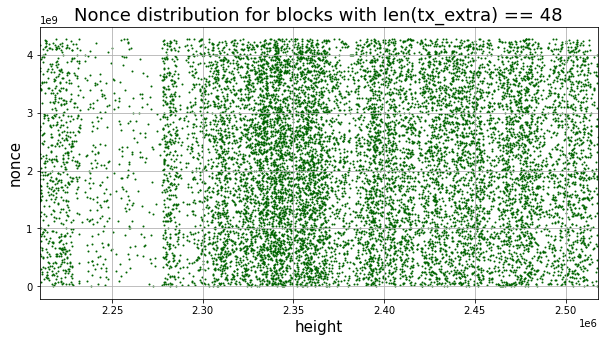

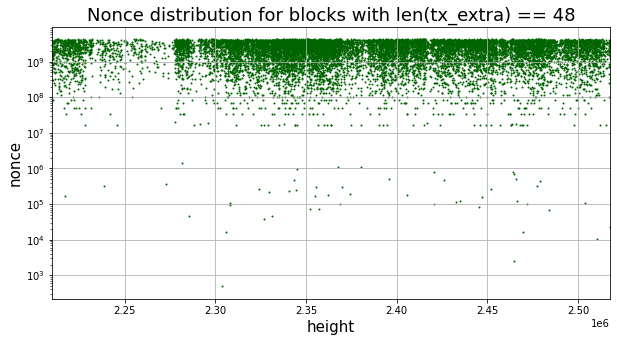

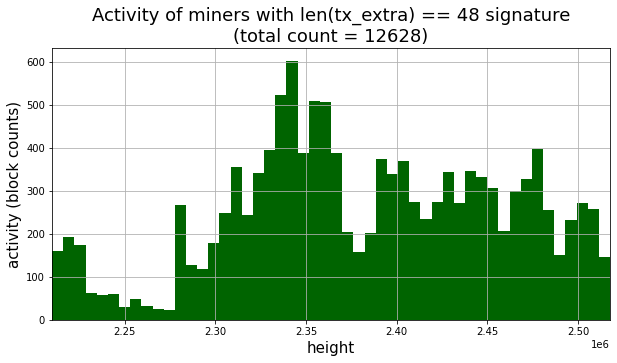

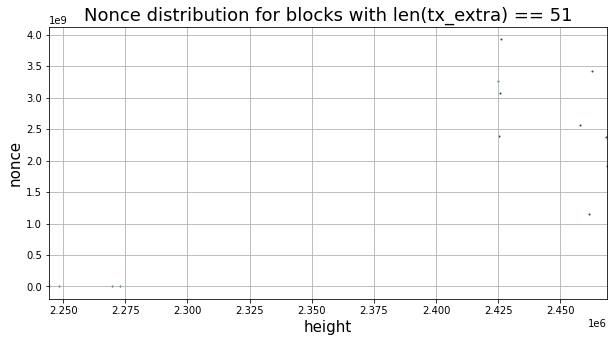

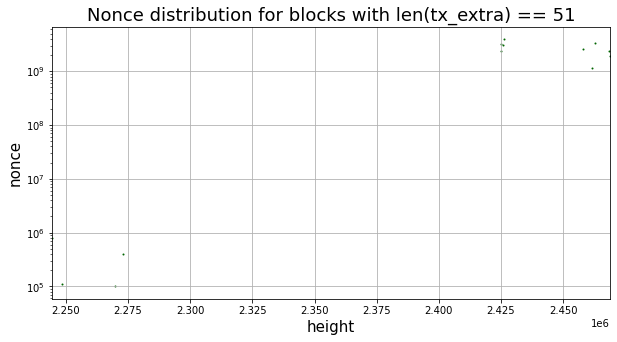

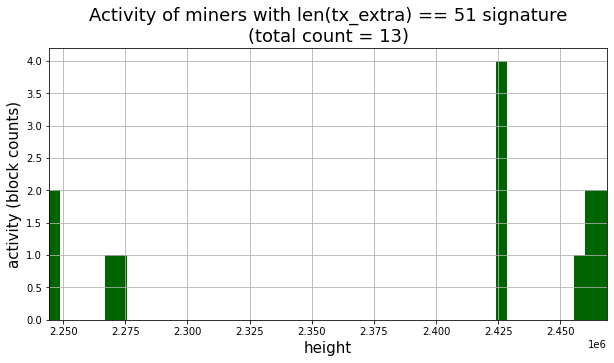

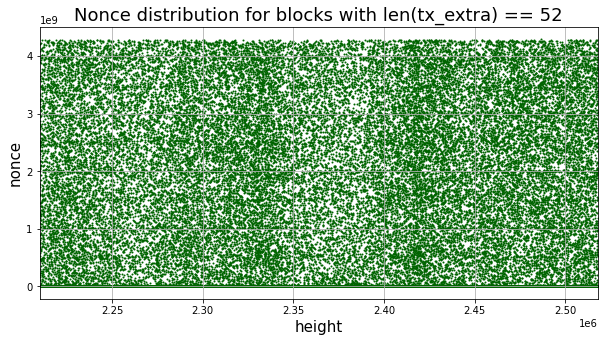

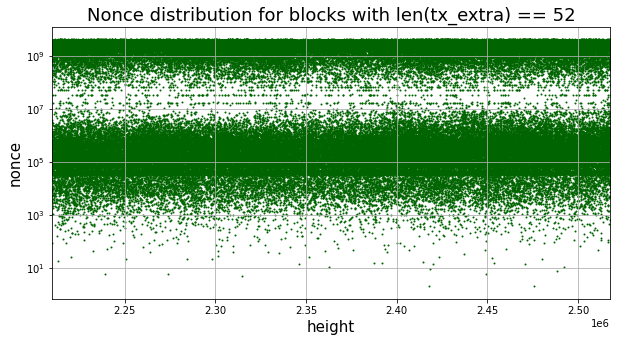

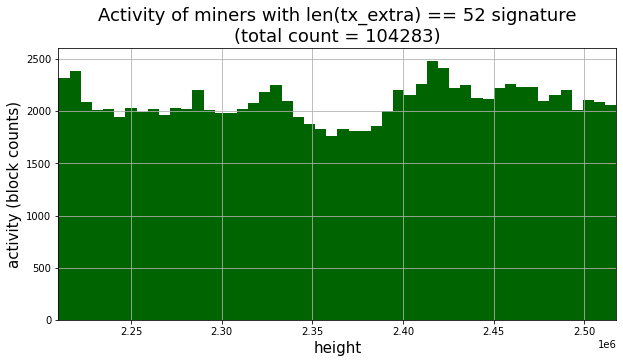

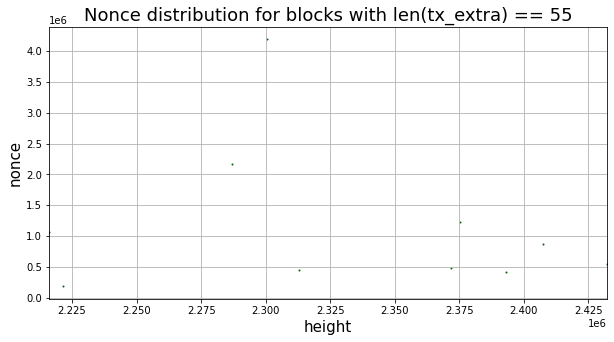

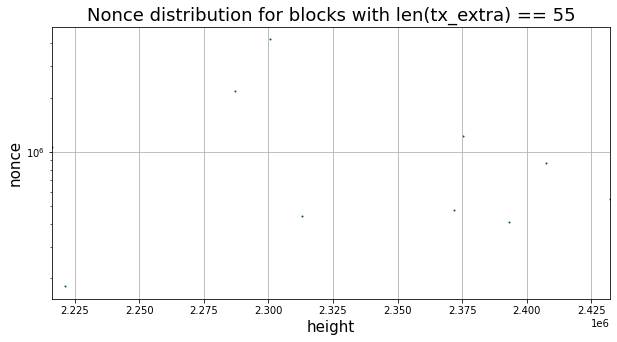

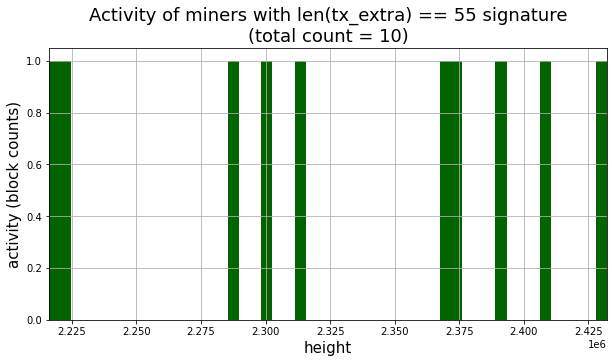

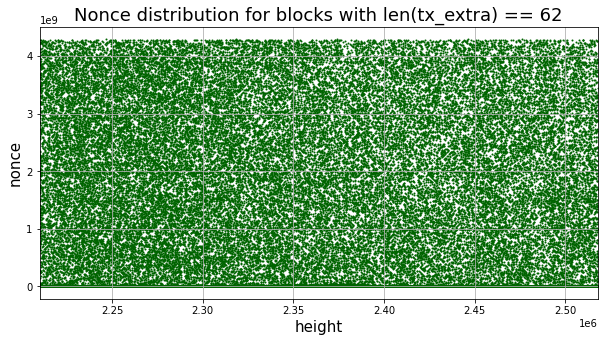

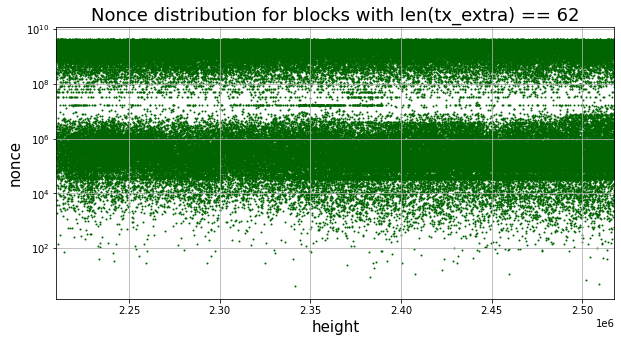

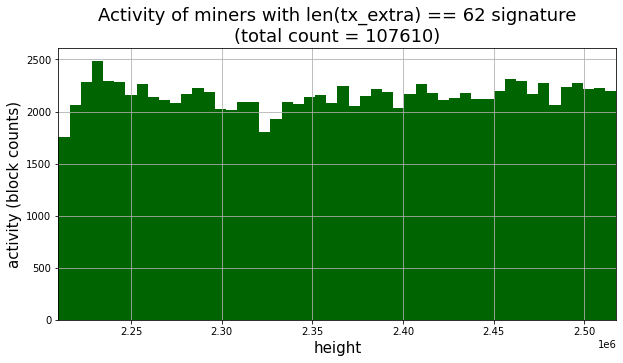

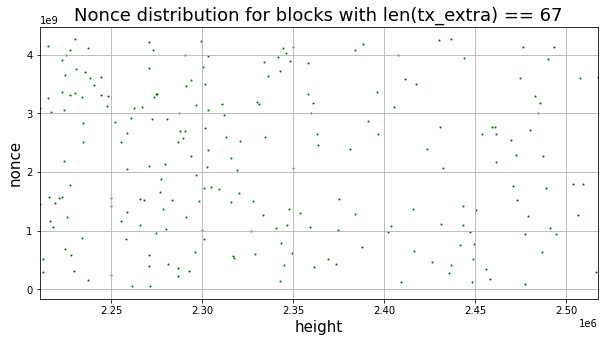

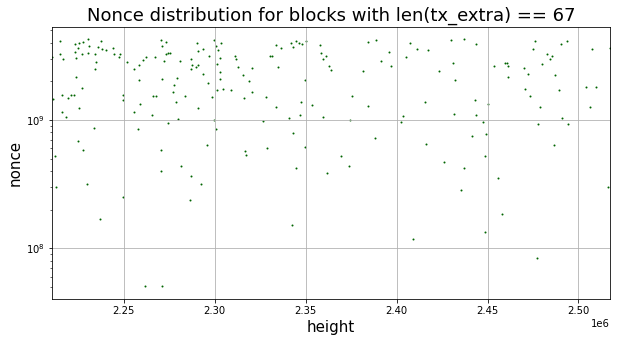

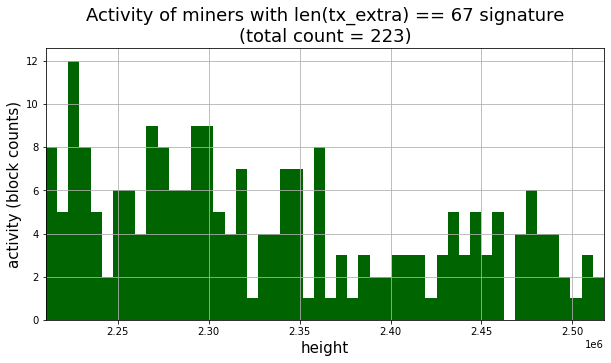

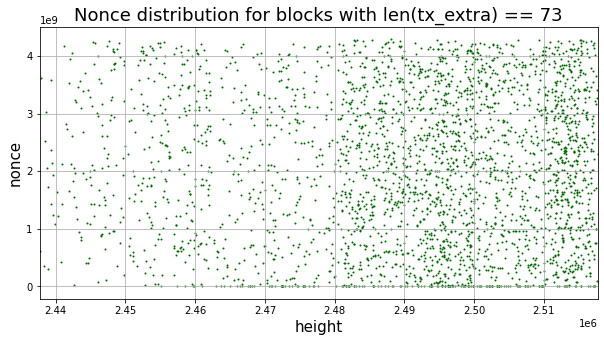

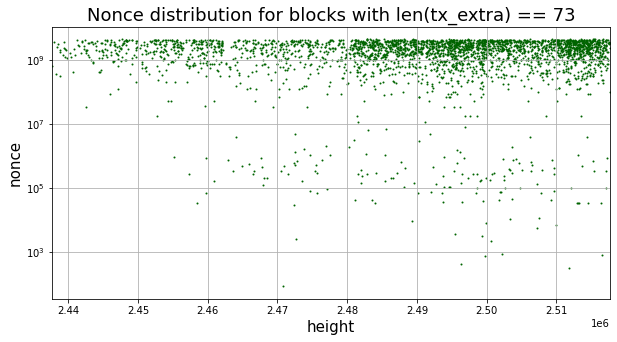

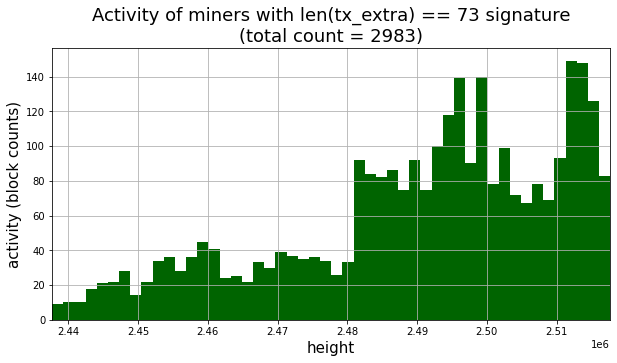

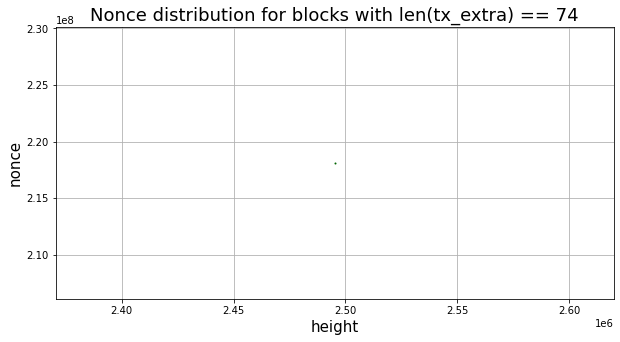

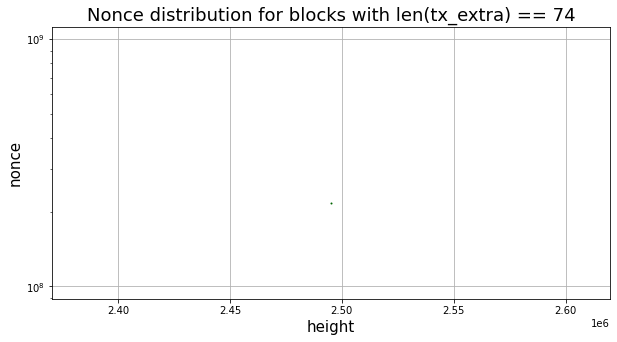

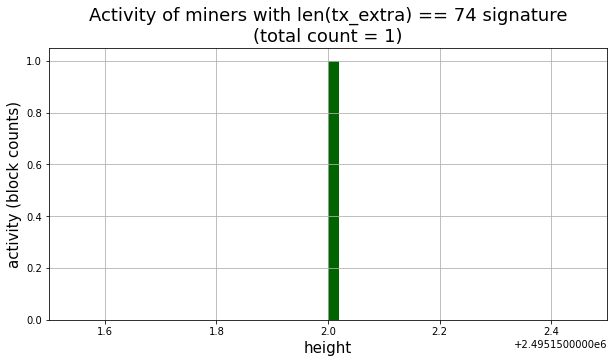

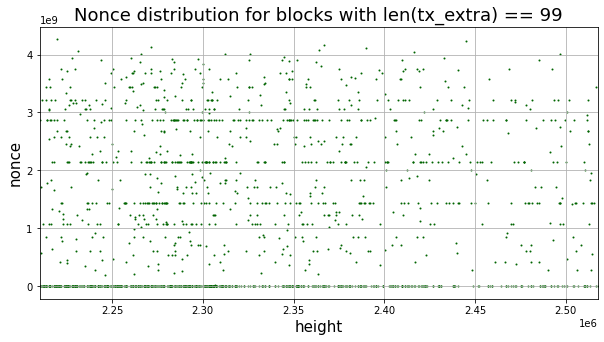

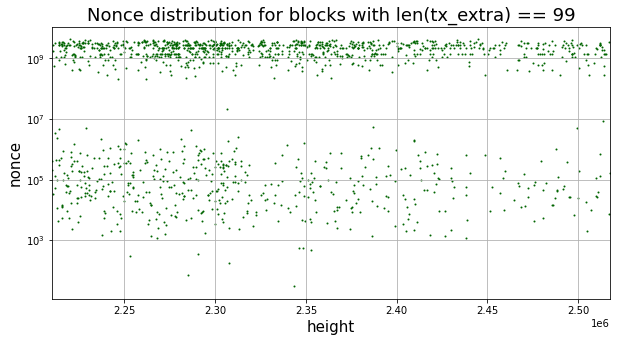

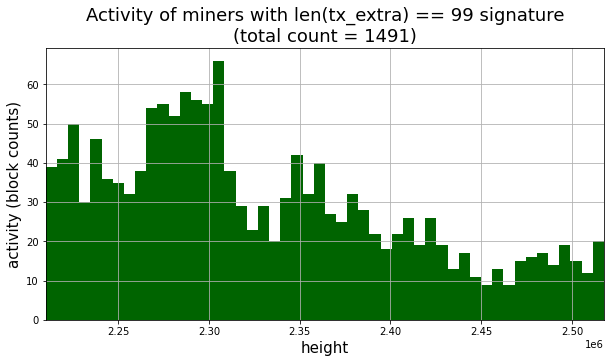

In [11]:
runs: List[List[int]] = []
for length in sorted(list(signatures)):
    df_filter: pd.Series = df_recent.loc[:, 'coinbase_len_tx_extra'] == length
    isthmuslib.scatter(df_recent[df_filter], 'block_height', 'block_nonce', xlabel='height', ylabel='nonce',
                      title=f"Nonce distribution for blocks with len(tx_extra) == {length}", markersize=1,
                      log_axes='', figsize=(10, 5))
    isthmuslib.scatter(df_recent[df_filter], 'block_height', 'block_nonce', xlabel='height', ylabel='nonce',
                      title=f"Nonce distribution for blocks with len(tx_extra) == {length}", markersize=1,
                      log_axes='y', figsize=(10, 5))
#     isthmuslib.scatter(df['block_height'], [flip_bitstring(x) for x in df['block_nonce']], 
#                       xlabel='height', ylabel='FLIPPED nonce',
#                       title=f"Nonce distribution for blocks with len(tx_extra) == {length}", markersize=1,
#                       log_axes='', figsize=(10, 5))
    isthmuslib.hist(df_recent[df_filter], 'block_height', xlabel='height', ylabel='activity (block counts)',
                      title=f"Activity of miners with len(tx_extra) == {length} signature"+
                      f"\n(total count = {sum(df_filter)})", markersize=1,
                      log_axes='', figsize=(10, 5), bins=50)
    isthmuslib.plt.show()
    runs.append(df_recent[df_filter].block_height.to_list())

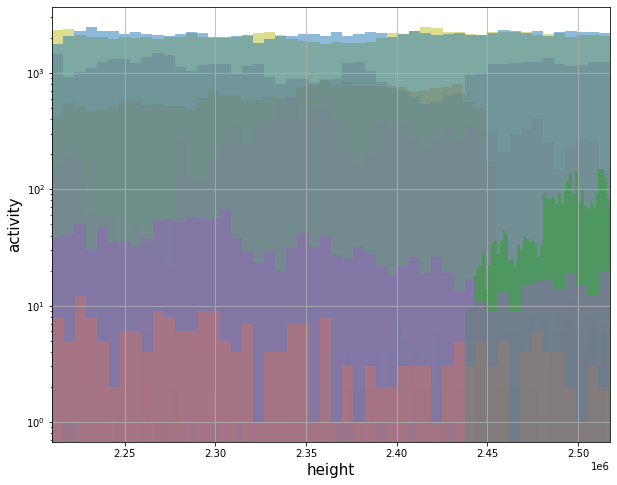

In [12]:
# Ugly histogram, these need to be stacked... 
isthmuslib.hist(runs, bins=50, log_axes='y', xlabel='height', ylabel='activity');